# Ordinary Least Squares (OLS) Imputation

This notebook demonstrates how to use MicroImpute's OLS imputer to impute values using linear regression. OLS imputation is a parametric approach that assumes a linear relationship between the predictor variables and the variable being imputed.

Currently, a single QRF object can only impute on one variable at a time.

## Setup and Data Preparation

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

# Import MicroImpute tools
from microimpute.comparisons.data import preprocess_data
from microimpute.evaluations import *
from microimpute.models import OLS
from microimpute.config import QUANTILES

In [3]:
# Load the diabetes dataset
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Display the first few rows of the dataset
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [4]:
# Define variables for the model
predictors = ["age", "sex", "bmi", "bp"]
imputed_variables = ["s1"]  # We'll impute 's1' (total serum cholesterol)

# Create a subset with only needed columns
diabetes_df = df[predictors + imputed_variables]

# Display summary statistics
diabetes_df.describe()

,age,sex,bmi,bp,s1
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01


In [5]:
# Split data into training and testing sets
X_train, X_test = preprocess_data(diabetes_df)

# Let's see how many records we have in each set
print(f"Training set size: {X_train.shape[0]} records")
print(f"Testing set size: {X_test.shape[0]} records")

Training set size: 353 records
Testing set size: 89 records


## Simulating Missing Data

For this example, we'll simulate missing data in our test set by removing the values we want to impute.

In [6]:
# Create a copy of the test set with missing values
X_test_missing = X_test.copy()

# Store the actual values for later comparison
actual_values = X_test_missing[imputed_variables].copy()

# Remove the values to be imputed
X_test_missing[imputed_variables] = np.nan

X_test_missing.head()

,age,sex,bmi,bp,s1
287,0.952161,-0.937474,-0.130325,-0.335978,NaN
211,1.943844,-0.937474,0.775037,0.459320,NaN
72,1.333577,1.064282,-0.085057,-0.263679,NaN
321,2.020127,-0.937474,1.091914,1.664559,NaN
73,0.265611,1.064282,-0.424568,-0.046779,NaN


## Training and Using the OLS Imputer

Now we'll train the OLS imputer and use it to impute the missing values in our test set.

In [9]:
# Initialize the OLS imputer
ols_imputer = OLS()

# Fit the model with our training data
# This trains a linear regression model
fitted_ols_imputer = ols_imputer.fit(X_train, predictors, imputed_variables)

In [10]:
# Impute values in the test set
# This uses the trained OLS model to predict missing values
imputed_values = fitted_ols_imputer.predict(X_test_missing, QUANTILES)

# Display the first few imputed values at the median (0.5 quantile)
imputed_values[0.5].head()

,0
287,0.155044
211,0.624045
72,0.172395
321,0.828508
73,-0.098537


## Evaluating the Imputation Results

Now let's compare the imputed values with the actual values to evaluate the performance of our imputer.

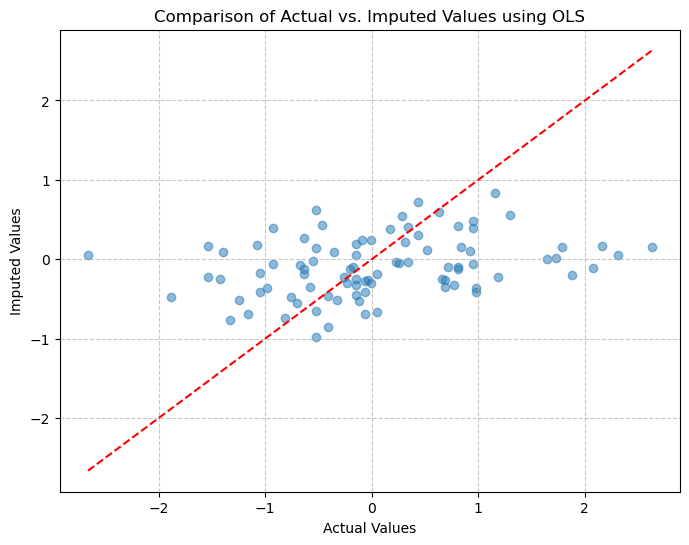

In [11]:
# Extract median predictions for evaluation
median_predictions = imputed_values[0.5]

# Create a scatter plot comparing actual vs. imputed values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, median_predictions, alpha=0.5)
plt.plot([actual_values.min().min(), actual_values.max().max()], 
         [actual_values.min().min(), actual_values.max().max()], 
         'r--')
plt.xlabel('Actual Values')
plt.ylabel('Imputed Values')
plt.title('Comparison of Actual vs. Imputed Values using OLS')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Examining Quantile Predictions

The OLS imputer generates quantile predictions based on the normal distribution assumption, which can help understand prediction uncertainty.

In [12]:
# Compare predictions at different quantiles for the first 5 records
quantiles_to_show = QUANTILES
comparison_df = pd.DataFrame(index=range(5))

# Add actual values
comparison_df['Actual'] = actual_values.iloc[:5, 0].values

# Add quantile predictions
for q in quantiles_to_show:
    comparison_df[f'Q{int(q*100)}'] = imputed_values[q].iloc[:5, 0].values

comparison_df

,Actual,Q5,Q10,Q30,Q50,Q70,Q90,Q95
0,2.625393,-1.392277,-1.050518,-0.338262,0.155044,0.648350,1.360605,1.702365
1,-0.524163,-0.923276,-0.581516,0.130739,0.624045,1.117351,1.829607,2.171367
2,2.163073,-1.374926,-1.033166,-0.320911,0.172395,0.665701,1.377956,1.719716
3,1.151747,-0.718813,-0.377053,0.335202,0.828508,1.321814,2.034069,2.375829
4,0.805007,-1.645858,-1.304098,-0.591843,-0.098537,0.394769,1.107024,1.448784


## Assesing the Method's Performance

To check whether our model is overfitting and ensure robust results we can perform cross-validation and visualize the results.

In [15]:
# Run cross-validation on the same data set 
ols_results = cross_validate_model(
        OLS, diabetes_df, predictors, imputed_variables)

ols_results

,0.05,0.10,0.30,0.50,0.70,0.90,0.95
train,0.004182,0.007077,0.014658,0.017272,0.015878,0.008730,0.005318
test,0.004228,0.007158,0.014886,0.017529,0.016039,0.008802,0.005369


In [17]:
# Plot the results
plot_train_test_performance(ols_results)